In [1]:
import cv2
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import cv2
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D 

In [2]:
poses = pd.read_csv('../KITTI_visual_odometry/run_kinect_wheel/pose/1.txt', delimiter=' ', header=None)
print('Shape of position dataframe:', poses.shape)
poses[0][0]

Shape of position dataframe: (1, 7)


0.096073

In [3]:
import re
dataset_dir = '../KITTI_visual_odometry/run_kinect_wheel/pose/'

xyz_data = []




def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)
file_list =sorted_alphanumeric(os.listdir(dataset_dir))

# Process each file in the directory
for filename in file_list:
    if filename.endswith('.txt'):
        
        data = pd.read_csv(os.path.join(dataset_dir, filename), delimiter=' ', header=None)
       
        xyz = data.iloc[:, :3]
        
        xyz_data.append(xyz)



In [4]:
xyz= np.array(xyz_data)
xyz=xyz[:,0]
print(xyz[0:5])
xyz.shape


[[ 0.096073 -0.032031  0.859956]
 [ 0.276328 -0.042642  0.857246]
 [ 0.39937  -0.060834  0.855275]
 [ 0.524644 -0.069936  0.854395]
 [ 0.644923 -0.080427  0.855031]]


(743, 3)

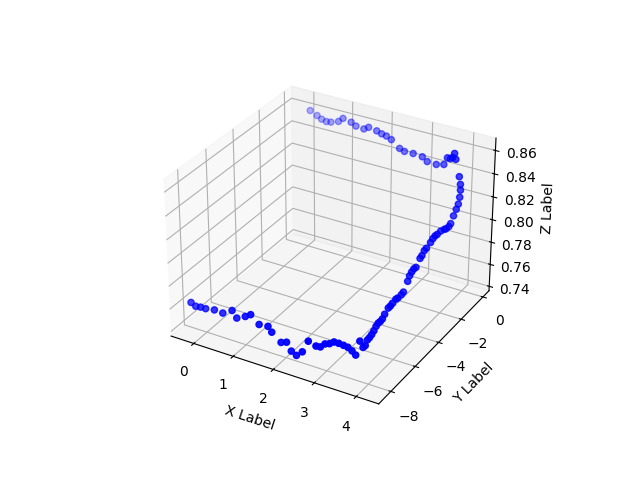

In [5]:
x= xyz[:100,0]
y=xyz[:100,1]
z=xyz[:100,2]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data
ax.scatter(x, y, z, c='b')

# Set axis labels
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Show the plot
plt.show()

(1536, 2048, 3)


dtype('uint8')

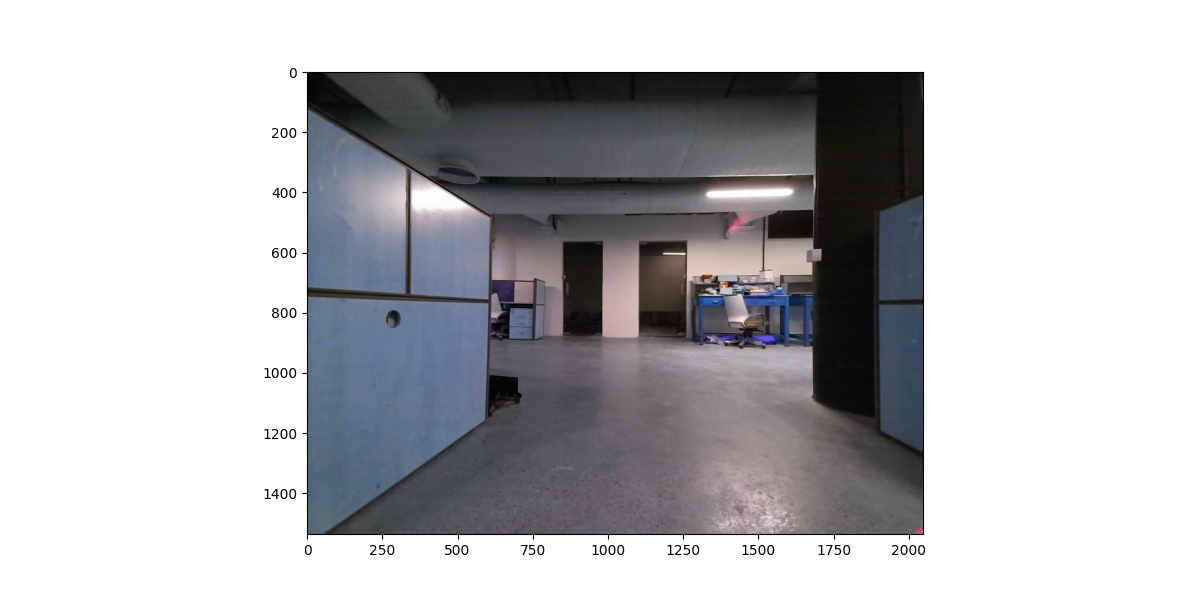

In [7]:
test_img = cv2.imread('../KITTI_visual_odometry/run_kinect_wheel/rgb/1.png')
plt.figure(figsize=(12,6))
plt.imshow(test_img)
print(test_img.shape)
test_img.dtype

In [8]:
class Dataset_Handler():
    def __init__(self, sequence):
               
        # Set file paths and get ground truth poses
        self.seq_dir='../KITTI_visual_odometry/run_kinect_wheel/rgb/'
        self.depth_dir='../KITTI_visual_odometry/run_kinect_wheel/depth/'
        # Get names of files to iterate through
        self.image_files = os.listdir(self.seq_dir)
        self.image_files= sorted_alphanumeric(self.image_files)
        
      
        self.num_frames = len(self.image_files)

        self.depth_files = os.listdir(self.depth_dir)
        self.depth_files= sorted_alphanumeric(self.depth_files)

        
    
        
        self.reset_frames()
        


        self.first_image = cv2.imread(self.seq_dir
                                            + self.image_files[0], 0)
        self.second_image = cv2.imread(self.seq_dir
                                            + self.image_files[1], 0)
        self.imheight = self.first_image.shape[0]
        self.imwidth = self.first_image.shape[1]

        self.first_image_depth = cv2.imread(self.depth_dir
                                            + self.depth_files[0], 0)
        
        self.second_image_depth = cv2.imread(self.depth_dir
                                            + self.depth_files[1], 0)
        
        
            
    def reset_frames(self):
        # Resets all generators to the first frame of the sequence
        self.images_rgb = (cv2.imread(self.seq_dir+ name_left, 0)
                            for name_left in self.image_files)
        
        self.images_depth = (cv2.imread(self.depth_dir+ depth_left, 0)
                            for depth_left in self.depth_files)
    
        pass


In [9]:
handler = Dataset_Handler('00')

(1536, 2048)
(1536, 2048)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]], dtype=uint8)

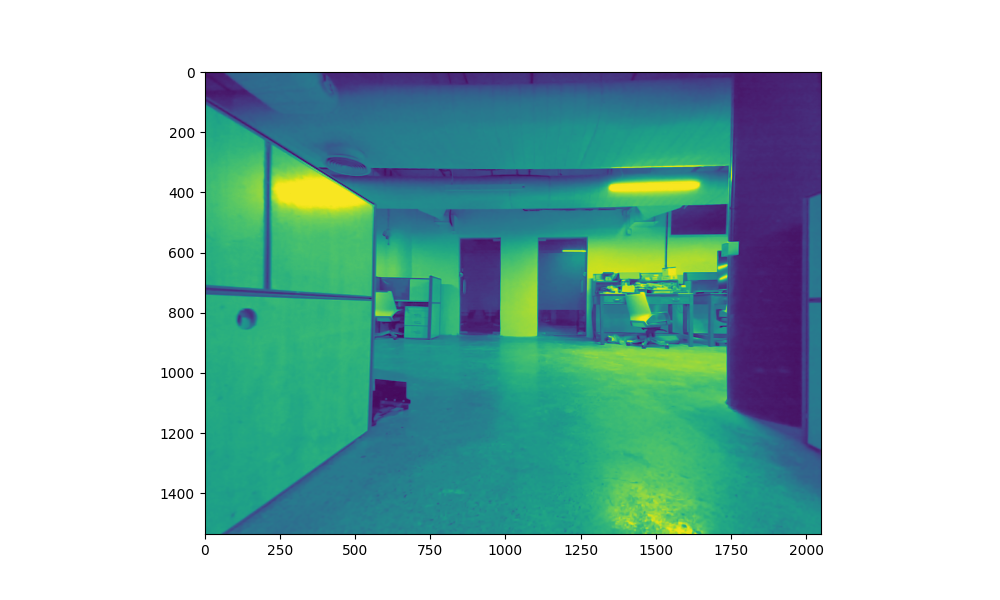

In [10]:
plt.figure(figsize=(10,6))
plt.imshow(handler.second_image)
print(handler.second_image_depth.shape)
print(handler.second_image.shape)
handler.second_image_depth

In [11]:

np.unique(handler.second_image_depth)
bb= handler.second_image_depth.astype(np.float64)
print(bb.dtype)

float64


In [12]:

def extract_features(image, detector='sift', mask=None):
  
    if detector == 'sift':
        det = cv2.SIFT_create()
    elif detector == 'orb':
        det = cv2.ORB_create()
    elif detector == 'surf':
        det = cv2.xfeatures2d.SURF_create()
        
    kp, des = det.detectAndCompute(image, mask)
    
    return kp, des

In [13]:
def match_features(des1, des2, matching='BF', detector='sift', sort=True, k=2):
   
    if matching == 'BF':
        if detector == 'sift':
            matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
        elif detector == 'orb':
            matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)
        matches = matcher.knnMatch(des1, des2, k=k)
   
    if sort:
        matches = sorted(matches, key = lambda x:x[0].distance)

    return matches

In [14]:
def filter_matches_distance(matches, dist_threshold):


    filtered_match = []
    for m, n in matches:
        if m.distance <= dist_threshold*n.distance:
            filtered_match.append(m)

    return filtered_match

In [15]:
def visualize_matches(image1, kp1, image2, kp2, match):
    
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2)
    plt.figure(figsize=(11, 6), dpi=100)
    plt.imshow(image_matches)

Number of matches before filtering: 1031
Number of matches after filtering: 252


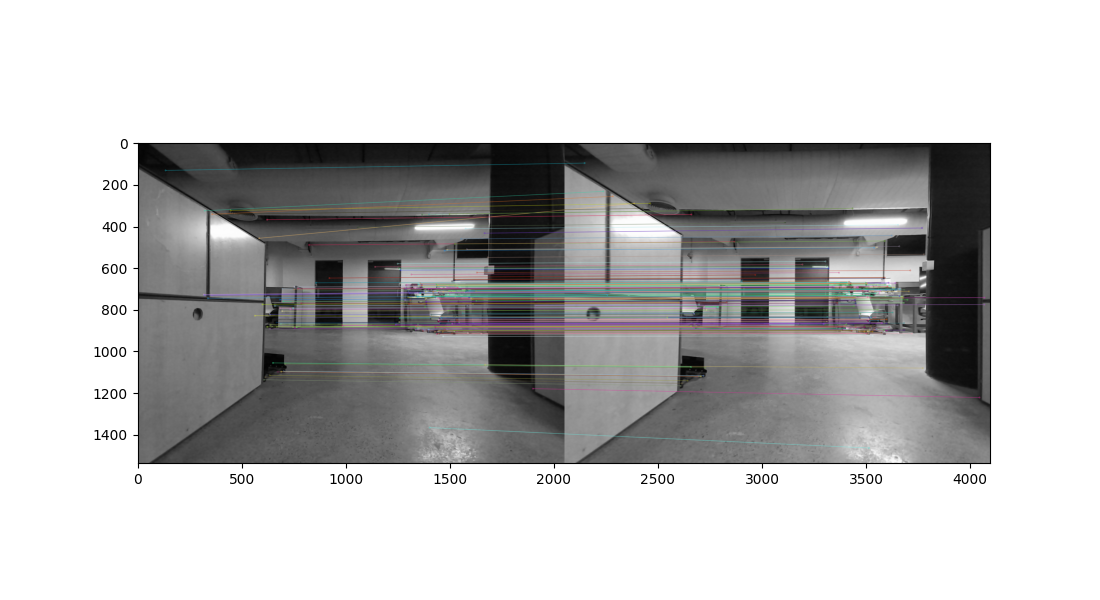

In [16]:
image_0 = handler.first_image
image_plus1 = handler.second_image

kp0, des0 = extract_features(image_0, 'sift')
kp1, des1 = extract_features(image_plus1, 'sift')
matches = match_features(des0, des1, matching='BF', detector='sift', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.5)
print('Number of matches after filtering:', len(matches))
visualize_matches(image_0, kp0, image_plus1, kp1, matches)

In [17]:
def estimate_motion(match, kp1, kp2, k, depth1=None, max_depth=3000):
   
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    
    image1_points = np.float32([kp1[m.queryIdx].pt for m in match])
    image2_points = np.float32([kp2[m.trainIdx].pt for m in match])

    #if depth1 is not None:
    cx = k[0, 2]
    cy = k[1, 2]
    fx = k[0, 0]
    fy = k[1, 1]
    object_points = np.zeros((0, 3))
    delete = []

    
    for i, (u, v) in enumerate(image1_points):
        z = depth1[int(v), int(u)]
    
        if z > max_depth:
            delete.append(i)
            continue
            
        # Use arithmetic to extract x and y (faster than using inverse of k)
        x = z*(u-cx)/fx
        y = z*(v-cy)/fy
        object_points = np.vstack([object_points, np.array([x, y, z])])
        
    image1_points = np.delete(image1_points, delete, 0)
    image2_points = np.delete(image2_points, delete, 0)
    

    _, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, image2_points, k, None)
    
    rmat = cv2.Rodrigues(rvec)[0]

    # else:
        
    #     image1_points_hom = np.hstack([image1_points, np.ones(len(image1_points)).reshape(-1,1)])
    #     image2_points_hom = np.hstack([image2_points, np.ones(len(image2_points)).reshape(-1,1)])
    #     E = cv2.findEssentialMat(image1_points, image2_points, k)[0]
    #     _, rmat, tvec, mask = cv2.recoverPose(E, image1_points, image2_points, k)
    
    return rmat, tvec, image1_points, image2_points

In [18]:
def visual_odometry(handler, detector='sift', matching='BF', filter_match_distance=None, 
                    subset=None):
    
   
    
    print('Detecting features with {} and matching with {}'.format(str.upper(detector), 
                                                                   matching))
    if filter_match_distance is not None:
        print('Filtering feature matches at threshold of {}*distance'.format(filter_match_distance))

    if subset is not None:
      
        num_frames = subset
    else:
       
        num_frames = handler.num_frames
        
          
    T_tot = np.eye(4)
    trajectory = np.zeros((num_frames, 3, 4))
    trajectory[0] = T_tot[:3, :]
    
    
    #intrinsic
    k_mat = np.array([[9.7096624755859375e+02, 0., 1.0272059326171875e+03], 
                  [0., 9.7109600830078125e+02, 7.7529718017578125e+02], 
                  [0., 0., 1]])
    
    
    handler.reset_frames()
    image_plus1 = next(handler.images_rgb)
    depth_plus1 = next(handler.images_depth)
    
    
    # Iterate 
    for i in range(num_frames - 1):  
   
        start = datetime.datetime.now()
       
        
        image_0 = image_plus1
      
        image_plus1 = next(handler.images_rgb)

        depth_0= depth_plus1.astype(np.float64)
        depth_plus1= next(handler.images_depth)
   
 
        kp0, des0 = extract_features(image_0, detector)
        kp1, des1 = extract_features(image_plus1, detector)
        
        matches_unfilt = match_features(des0, 
                                        des1, 
                                        matching=matching, 
                                        detector=detector, 
                                        sort=True)
        
        if filter_match_distance is not None:
            matches = filter_matches_distance(matches_unfilt, filter_match_distance)
        else:
            matches = matches_unfilt
            
      
        rmat, tvec, img1_points, img2_points = estimate_motion(matches, kp0, kp1, k_mat, depth_0)
      
        Tmat = np.eye(4)
    
        Tmat[:3, :3] = rmat
        Tmat[:3, 3] = tvec.T
        
        
        T_tot = T_tot.dot(np.linalg.inv(Tmat))
            
        
        trajectory[i+1, :, :] = T_tot[:3, :]
        
        end = datetime.datetime.now()
        print('Time to compute frame {}:'.format(i+1), end-start)
    return trajectory

In [29]:

start = datetime.datetime.now()
trajectory_nolidar_bm = visual_odometry(handler,
                                        filter_match_distance=0.4, 
                                        detector='sift', 
                                        matching='sgbm',    
                                        subset=None)
end = datetime.datetime.now()
print('Time to perform odometry:', end-start)

Detecting features with SIFT and matching with BF
Filtering feature matches at threshold of 0.4*distance
Time to compute frame 1: 0:00:00.665379
Time to compute frame 2: 0:00:00.624626
Time to compute frame 3: 0:00:00.654453
Time to compute frame 4: 0:00:00.609200
Time to compute frame 5: 0:00:00.619417
Time to compute frame 6: 0:00:00.694926
Time to compute frame 7: 0:00:00.621454
Time to compute frame 8: 0:00:00.621929
Time to compute frame 9: 0:00:00.612426
Time to compute frame 10: 0:00:00.594735
Time to compute frame 11: 0:00:00.625515
Time to compute frame 12: 0:00:00.689854
Time to compute frame 13: 0:00:00.912629
Time to compute frame 14: 0:00:00.635864
Time to compute frame 15: 0:00:00.619740
Time to compute frame 16: 0:00:00.620706
Time to compute frame 17: 0:00:00.620470
Time to compute frame 18: 0:00:00.684965
Time to compute frame 19: 0:00:00.612072
Time to compute frame 20: 0:00:00.620322
Time to compute frame 21: 0:00:00.637418
Time to compute frame 22: 0:00:00.651640
Ti

In [19]:
np.savetxt('trajectory_hardware.csv', trajectory_nolidar_bm.reshape(-1, trajectory_nolidar_bm.shape[-1]), delimiter=',')


NameError: name 'trajectory_nolidar_bm' is not defined

In [12]:
loaded_trajectory = np.loadtxt('trajectory_hardware.csv', delimiter=',')
# Reshape the loaded data back to the original shape if needed
loaded_trajectory = loaded_trajectory.reshape(743,3,4)  #handler.num_frames

In [13]:

def calculate_error(ground_truth, estimated, error_type='mse'):
    
  
    nframes_est = estimated.shape[0]
    
    def get_mse(ground_truth, estimated):
        se = np.sqrt((ground_truth[nframes_est, 0, 3] - estimated[:, 0, 3])**2 
                    + (ground_truth[nframes_est, 1, 3] - estimated[:, 1, 3])**2 
                    + (ground_truth[nframes_est, 2, 3] - estimated[:, 2, 3])**2)**2
        mse = se.mean()
        return mse
    
    def get_mae(ground_truth, estimated):
        ae = np.sqrt((ground_truth[nframes_est, 0, 3] - estimated[:, 0, 3])**2 
                    + (ground_truth[nframes_est, 1, 3] - estimated[:, 1, 3])**2 
                    + (ground_truth[nframes_est, 2, 3] - estimated[:, 2, 3])**2)
        mae = ae.mean()
        return mae
    
    if error_type == 'mae':
        return get_mae(ground_truth, estimated)
    elif error_type == 'mse':
        return get_mse(ground_truth, estimated)
    elif error_type == 'rmse':
        return np.sqrt(get_mse(ground_truth, estimated))
    elif error_type == 'all':
        mae = get_mae(ground_truth, estimated)
        mse = get_mse(ground_truth, estimated)
        rmse = np.sqrt(mse)
        return {'mae': mae,
                'rmse': rmse,
                'mse': mse}

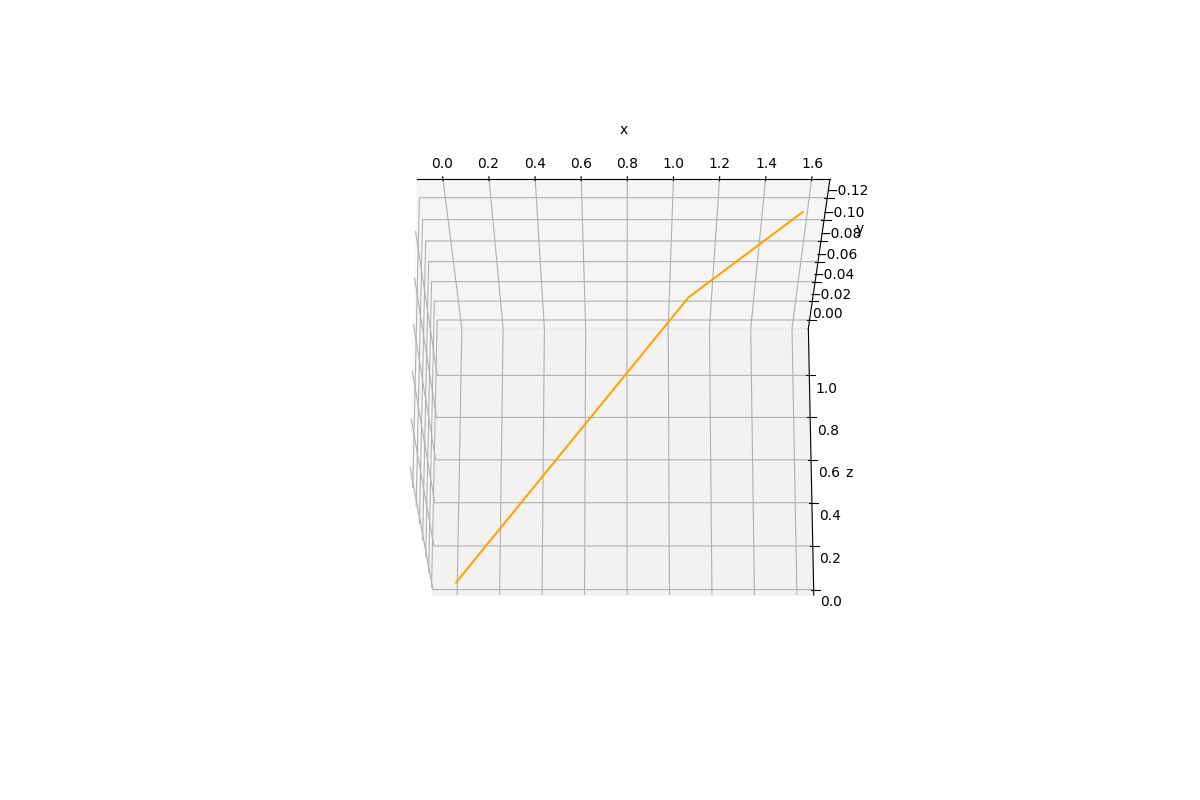

In [14]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(loaded_trajectory[:, :, 3][:, 0], 
        loaded_trajectory[:, :, 3][:, 1], 
        loaded_trajectory[:, :, 3][:, 2], label='estimated', color='orange')



ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(elev=-20, azim=270)